In [1]:
#import needed packages
import pandas as pd
import sqlite3 as db
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os

In [47]:
current_path = os.path.abspath(os.path.dirname("CDA Project"))

In [5]:
#read all data in
current_path = os.path.abspath(os.path.dirname("CDA Project"))
application_train=pd.read_csv(current_path+r'\source\application_train.csv')
bureau_balance = pd.read_csv (current_path+r'\source\bureau_balance.csv')
bureau = pd.read_csv (current_path+r'\source\bureau.csv')
credit_card_balance = pd.read_csv (current_path+r'\source\credit_card_balance.csv')
installments_payments = pd.read_csv (current_path+r'\source\installments_payments.csv')
pos_cash_balance = pd.read_csv (current_path+r'\source\POS_CASH_balance.csv')
previous_application = pd.read_csv (current_path+r'\source\previous_application.csv')

In [7]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Connect to a database for SQL
conn = db.connect('cda.db')

# Create a 'cursor' for executing commands
c = conn.cursor()

In [28]:
#load everything into database
application_train.to_sql("application_train", conn, if_exists="replace")
bureau_balance.to_sql("bureau_balance", conn, if_exists="replace")
bureau.to_sql("bureau", conn, if_exists="replace")
credit_card_balance.to_sql("credit_card_balance", conn, if_exists="replace")
installments_payments.to_sql("installments_payments", conn, if_exists="replace")
pos_cash_balance.to_sql("pos_cash_balance", conn, if_exists="replace")
previous_application.to_sql("previous_application", conn, if_exists="replace")

1670214

In [3]:
# first join on SK_ID_CURR to previous_application
c.execute("DROP TABLE IF EXISTS prvs_app_max")

#multiple previous applications, just keeping the highest amount here
#also considered using the most recent but there are no dates 
query = '''
        CREATE TABLE prvs_app_max as
        SELECT *
              ,max(AMT_CREDIT) AS PRVS_APP_MAX_AMT_CREDIT 
        FROM previous_application
        GROUP BY SK_ID_CURR
'''

c.execute(query)

In [4]:
c.execute("DROP TABLE IF EXISTS app_train_prvs")

query = '''
    CREATE TABLE app_train_prvs as 
    SELECT a.*
          ,b.*
    FROM application_train a
    LEFT JOIN prvs_app_max b
    ON a.SK_ID_CURR = b.SK_ID_CURR
   
'''

c.execute(query)

In [5]:
#join on SK_ID_CURR to bureau

c.execute("DROP TABLE IF EXISTS credit_distinct")

#this logic prioritizes active credit open and then takes the maximum
query = '''
    CREATE TABLE credit_distinct AS
    SELECT * FROM
    (SELECT *
          ,ROW_NUMBER() OVER (PARTITION BY SK_ID_CURR 
                              ORDER BY (CASE WHEN CREDIT_ACTIVE = 'Active' then 1 else 0 end) DESC
                                      ,AMT_CREDIT_SUM DESC) AS ROW_CREDIT
    FROM bureau)
    WHERE ROW_CREDIT = 1
'''

c.execute(query)


In [6]:
c.execute("DROP TABLE IF EXISTS app_train_prvs_credit")

query = '''
    CREATE TABLE app_train_prvs_credit as 
    SELECT a.*
          ,b.*
    FROM app_train_prvs a
    LEFT JOIN credit_distinct b
    ON a.SK_ID_CURR = b.SK_ID_CURR
   
'''

c.execute(query)

In [7]:
#join to bureau_balance using SK_ID_BUREAU
#for this one use sum(months_balance)

c.execute("DROP TABLE IF EXISTS bureau_balance_distinct")

#this logic prioritizes active credit open and then takes the maximum
query = '''
    CREATE TABLE bureau_balance_distinct AS
    SELECT *
          ,sum(months_balance) as TOTAL_MONTHS_BALANCE
    FROM bureau_balance
    GROUP BY SK_ID_BUREAU
'''

c.execute(query)

In [8]:
c.execute("DROP TABLE IF EXISTS app_bureau_balance")

query = '''
    CREATE TABLE app_bureau_balance as 
    SELECT a.*
          ,b.total_months_balance
          ,b.status
    FROM app_train_prvs_credit a
    LEFT JOIN bureau_balance_distinct b
    ON a.SK_ID_BUREAU = b.SK_ID_BUREAU
   
'''

c.execute(query)

In [9]:
#get the pos_cash balance table ready for join 

c.execute("DROP TABLE IF EXISTS POS_DISTINCT")

query = '''
        CREATE TABLE POS_DISTINCT AS 
        SELECT SK_ID_PREV
              ,SK_ID_CURR
              ,SUM(MONTHS_BALANCE) AS POS_TOTAL_MONTHS_BALANCE
              ,MAX(CNT_INSTALMENT) AS MAX_CNT_INSTALLMENT
              ,MAX(CNT_INSTALMENT_FUTURE) AS MAX_CNT_INSTALLMENT_FUTURE
              ,NAME_CONTRACT_STATUS
        FROM pos_cash_balance
        GROUP BY SK_ID_PREV
        order by SK_ID_PREV
'''

c.execute(query)

In [10]:
#get the installments payments table ready for join 

c.execute("DROP TABLE IF EXISTS INSTALMENTS_DISTINCT")

query = '''
        CREATE TABLE INSTALMENTS_DISTINCT AS 
        SELECT *
              ,MAX(AMT_INSTALMENT) AS MAX_AMT_INSTALMENT
        FROM installments_payments
        GROUP BY SK_ID_PREV
        order by SK_ID_PREV
'''

c.execute(query)

In [11]:
#get the credit card balance table ready for join
#taking the max amount balance

c.execute("DROP TABLE IF EXISTS CCB_DISTINCT")

query = '''
        CREATE TABLE CCB_DISTINCT AS 
        SELECT *
              ,MAX(AMT_BALANCE) as CCB_MAX_AMT_BALANCE
        FROM credit_card_balance
        WHERE NAME_CONTRACT_STATUS = 'Active'
        GROUP BY SK_ID_PREV
        order by SK_ID_PREV
'''

c.execute(query)

In [12]:
#join it all

c.execute("DROP TABLE IF EXISTS FINAL_APPLICATION_TRAIN")

query = '''
        CREATE TABLE FINAL_APPLICATION_TRAIN AS 
        SELECT a.*
              ,b.pos_total_months_balance
              ,b.max_cnt_installment
              ,b.max_cnt_installment_future
              ,b.NAME_CONTRACT_STATUS
              ,c.max_amt_instalment
              ,c.amt_payment
              ,c.num_instalment_version
              ,c.days_instalment
              ,c.days_entry_payment
              ,d.CCB_MAX_AMT_BALANCE
              ,d.AMT_CREDIT_LIMIT_ACTUAL
              ,d.AMT_INST_MIN_REGULARITY
              ,d.AMT_RECIVABLE
              ,d.CNT_DRAWINGS_ATM_CURRENT
              ,d.CNT_INSTALMENT_MATURE_CUM
        FROM app_bureau_balance a
        LEFT JOIN POS_DISTINCT b
        on a.SK_ID_PREV = b.SK_ID_PREV
        LEFT JOIN INSTALMENTS_DISTINCT c
        on b.SK_ID_PREV = c.SK_ID_PREV
        LEFT JOIN CCB_DISTINCT d 
        on c.SK_ID_PREV = d.SK_ID_PREV
'''

c.execute(query)

In [13]:

query = '''
        SELECT *
        FROM FINAL_APPLICATION_TRAIN
        
'''

train_data = pd.read_sql_query(query, conn)
train_data

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,AMT_PAYMENT,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,CCB_MAX_AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_INST_MIN_REGULARITY,AMT_RECIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_INSTALMENT_MATURE_CUM
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,53093.745,2.0,-25.0,-49.0,None,None,None,None,None,None
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,560835.360,2.0,-536.0,-544.0,None,None,None,None,None,None
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,10573.965,2.0,-724.0,-727.0,None,None,None,None,None,None
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,...,12815.010,2.0,-30.0,-38.0,None,None,None,None,None,None
307507,307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,...,10074.465,1.0,-2376.0,-2376.0,None,None,None,None,None,None
307508,307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,...,5575.185,1.0,-1716.0,-1738.0,None,None,None,None,None,None
307509,307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,...,19065.825,1.0,-67.0,-78.0,None,None,None,None,None,None


In [14]:
#clean up database
c.execute("DROP TABLE IF EXISTS application_train")
c.execute("DROP TABLE IF EXISTS application_test")
c.execute("DROP TABLE IF EXISTS bureau_balance")
c.execute("DROP TABLE IF EXISTS bureau")
c.execute("DROP TABLE IF EXISTS credit_card_balance")
c.execute("DROP TABLE IF EXISTS installments_payments")
c.execute("DROP TABLE IF EXISTS pos_cash_balance")
c.execute("DROP TABLE IF EXISTS application_train")
c.execute("DROP TABLE IF EXISTS previous_application")
c.execute("DROP TABLE IF EXISTS app_train_prvs")
c.execute("DROP TABLE IF EXISTS credit_distinct")
c.execute("DROP TABLE IF EXISTS app_train_prvs_credit")
c.execute("DROP TABLE IF EXISTS bureau_balance_distinct")
c.execute("DROP TABLE IF EXISTS app_bureau_balance")
c.execute("DROP TABLE IF EXISTS POS_DISTINCT")
c.execute("DROP TABLE IF EXISTS INSTALMENTS_DISTINCT")
c.execute("DROP TABLE IF EXISTS CCB_DISTINCT")

Percentage of people who will not repay the loan on time:  8.072881945686495 %
Percentage of people who will repay the loan on time:  91.92711805431351 %


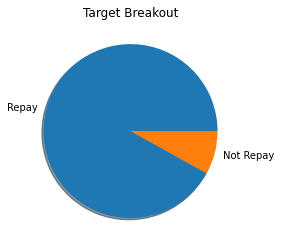

In [15]:
#take a look at breakout of the response 

target_count = train_data['TARGET'].value_counts()
print("Percentage of people who will not repay the loan on time: ",(target_count[1]/(target_count[1]+target_count[0]))*100,"%")
print("Percentage of people who will repay the loan on time: ",(target_count[0]/(target_count[1]+target_count[0]))*100,"%")

label = ["Repay", "Not Repay"]
plt.pie(target_count, labels = label, shadow = True)
plt.title("Target Breakout")
plt.show()

In [16]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Loans')
    plt.title('Number of loans aproved vs rejected')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Repay', 'not repay'))
    plt.show()
    
    
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

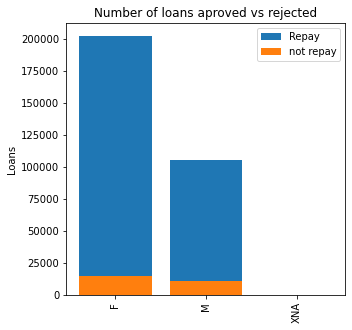

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [17]:
univariate_barplots(data = train_data, col1 = 'CODE_GENDER')

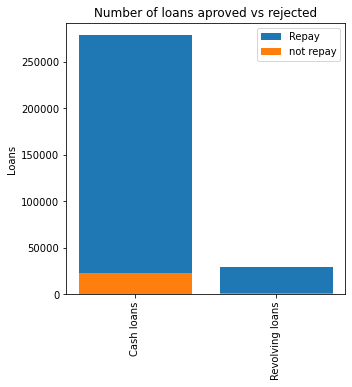

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [18]:
univariate_barplots(data = train_data, col1 = 'NAME_CONTRACT_TYPE')

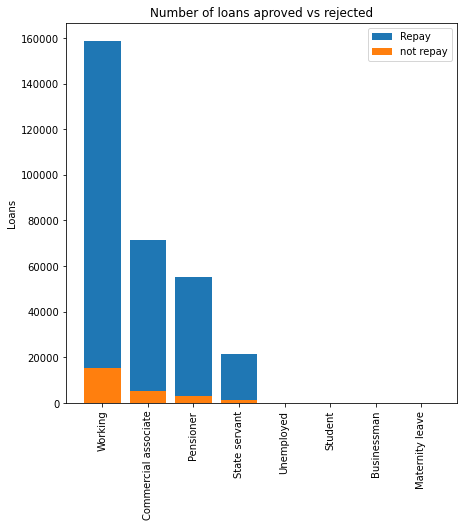

       NAME_INCOME_TYPE  TARGET   total       Avg
7               Working   15224  158774  0.095885
1  Commercial associate    5360   71617  0.074843
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
6            Unemployed       8      22  0.363636
  NAME_INCOME_TYPE  TARGET  total       Avg
4    State servant    1249  21703  0.057550
6       Unemployed       8     22  0.363636
5          Student       0     18  0.000000
0      Businessman       0     10  0.000000
2  Maternity leave       2      5  0.400000


In [19]:
univariate_barplots(data = train_data, col1 = 'NAME_INCOME_TYPE')

In [20]:
#lets look at missing values by column
def handle_missing(data):
    na_pct = pd.DataFrame(data.isnull().sum()/data.shape[0] * 100)
    na_name = na_pct.rename(columns ={0: '% Missing Values'}) #rename
    na_filter_non = na_name[na_name['% Missing Values'] != 0] #dont need to consider no missing
    na_sort = na_filter_non.sort_values('% Missing Values', ascending=False)
    return na_sort

In [21]:
missing_pct = handle_missing(train_data)
missing_pct.head(10)

,% Missing Values
CNT_INSTALMENT_MATURE_CUM,100.000000
CNT_DRAWINGS_ATM_CURRENT,100.000000
CCB_MAX_AMT_BALANCE,100.000000
AMT_RECIVABLE,100.000000
AMT_INST_MIN_REGULARITY,100.000000
AMT_CREDIT_LIMIT_ACTUAL,100.000000
RATE_INTEREST_PRIMARY,99.635135
RATE_INTEREST_PRIVILEGED,99.635135
DAYS_ENDDATE_FACT,84.889971
AMT_ANNUITY:2,80.335988


In [22]:
#drop anything with 70% and above missing
def drop_columns(data):
    data_drop = data.drop(['CNT_INSTALMENT_MATURE_CUM','CNT_DRAWINGS_ATM_CURRENT', 'CCB_MAX_AMT_BALANCE'
                           ,'AMT_RECIVABLE','AMT_INST_MIN_REGULARITY','AMT_CREDIT_LIMIT_ACTUAL','RATE_INTEREST_PRIMARY'
                           ,'RATE_INTEREST_PRIVILEGED','DAYS_ENDDATE_FACT','AMT_ANNUITY:2','AMT_CREDIT_MAX_OVERDUE'
                           ,'STATUS','TOTAL_MONTHS_BALANCE'], axis = 1)
    return data_drop


In [23]:
train_data_drop = drop_columns(train_data)

In [24]:
missing_pct = handle_missing(train_data_drop)
missing_pct.head(10)

,% Missing Values
COMMONAREA_MODE,69.872297
COMMONAREA_MEDI,69.872297
COMMONAREA_AVG,69.872297
NONLIVINGAPARTMENTS_MODE,69.432963
NONLIVINGAPARTMENTS_AVG,69.432963
NONLIVINGAPARTMENTS_MEDI,69.432963
FONDKAPREMONT_MODE,68.386172
LIVINGAPARTMENTS_MODE,68.354953
LIVINGAPARTMENTS_AVG,68.354953
LIVINGAPARTMENTS_MEDI,68.354953


In [25]:
print(train_data_drop.shape[0])
print(train_data_drop.dtypes.value_counts())

307511
float64    107
int64       42
object      36
dtype: int64


In [38]:
#check out the categorical variables,we probably need to do something about them
train_data_drop.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE               2
CODE_GENDER                      3
FLAG_OWN_CAR                     2
FLAG_OWN_REALTY                  2
NAME_TYPE_SUITE                  7
NAME_INCOME_TYPE                 8
NAME_EDUCATION_TYPE              5
NAME_FAMILY_STATUS               6
NAME_HOUSING_TYPE                6
OCCUPATION_TYPE                 18
WEEKDAY_APPR_PROCESS_START       7
ORGANIZATION_TYPE               58
FONDKAPREMONT_MODE               4
HOUSETYPE_MODE                   3
WALLSMATERIAL_MODE               7
EMERGENCYSTATE_MODE              2
NAME_CONTRACT_TYPE:1             3
WEEKDAY_APPR_PROCESS_START:1     7
FLAG_LAST_APPL_PER_CONTRACT      2
NAME_CASH_LOAN_PURPOSE          25
NAME_CONTRACT_STATUS             4
NAME_PAYMENT_TYPE                4
CODE_REJECT_REASON               9
NAME_TYPE_SUITE:1                7
NAME_CLIENT_TYPE                 4
NAME_GOODS_CATEGORY             27
NAME_PORTFOLIO                   5
NAME_PRODUCT_TYPE                3
CHANNEL_TYPE        

In [39]:
#use sklearn function to one hot encode
#onehot = OneHotEncoder(sparse=False)
#train_onehot = onehot.fit_transform(train_data_drop)

#nope this kept dying

#get dummies it is
train_onehot = pd.get_dummies(train_data_drop)

In [40]:
#correlation with target variable
correlations = train_onehot.corr()['TARGET'].sort_values()

In [41]:
#we could do some more looks on highly correlated features - they should be important
print(correlations.head(10))
print(correlations.tail(10))

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64
CODE_GENDER_M                   0.054713
DAYS_LAST_PHONE_CHANGE          0.055218
NAME_INCOME_TYPE_Working        0.057481
DAYS_CREDIT                     0.058315
REGION_RATING_CLIENT            0.058899
NAME_CONTRACT_STATUS_Refused    0.060789
REGION_RATING_CLIENT_W_CITY     0.060893
DAYS_BIRTH                      0.078239
TARGET                          1.000000
ROW_CREDIT                           NaN
Name: TARGET, dtype: float64


In [42]:
target = train_onehot['TARGET']
sk_id_curr = train_onehot['SK_ID_CURR']

In [43]:
train_onehot = train_onehot.drop(['TARGET','SK_ID_CURR','index'], axis = 1)
cols = list(train_onehot.columns)

In [44]:
#do some more preprocessing
#impute missing values
imputer = SimpleImputer(strategy = 'median').fit(train_onehot)
train_onehot = imputer.transform(train_onehot)

#now scale
scaler = MinMaxScaler(feature_range = (0,1)).fit(train_onehot)
train_onehot = scaler.transform(train_onehot)

In [45]:
#reconstruct the dataframe
train_onehot = pd.DataFrame(train_onehot, columns = cols)
train_onehot['TARGET'] = target

In [48]:
train_onehot.to_csv(current_path+r'/source/main_data.csv')

In [49]:
#split data up
X_train, X_test, y_train, y_test = train_test_split(train_onehot, train_onehot['TARGET'], test_size=0.3, random_state=0, stratify=train_onehot['TARGET'])

In [50]:
#quick check to make sure split is according to OG structure
print(y_train.value_counts()/len(y_train)*100)
print(y_test.value_counts()/len(y_test)*100) 
print(y_test.value_counts()/(y_test.value_counts()+y_train.value_counts()))

0    91.927324
1     8.072676
Name: TARGET, dtype: float64
0    91.926637
1     8.073363
Name: TARGET, dtype: float64
0    0.300001
1    0.300020
Name: TARGET, dtype: float64


In [51]:
#drop target columns from X
X_train = X_train.drop('TARGET', axis = 1)
X_test = X_test.drop('TARGET', axis = 1)

In [52]:
#do some feature selection, we dont need ALL the columns
#use randomforest
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 2340).fit(X_train, y_train)
feature_select = SelectFromModel(random_forest).fit(X_train, y_train).transform(X_train)

In [62]:
feature_selected = X_train.columns[(SelectFromModel(random_forest).get_support())]
type(feature_selected)

pandas.core.indexes.base.Index

In [64]:
X_train_transform = SelectFromModel(random_forest).transform(X_train)
X_train_transform = pd.DataFrame(X_train_transform, columns = feature_selected)
X_train_transform

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,MAX_CNT_INSTALLMENT,MAX_CNT_INSTALLMENT_FUTURE,MAX_AMT_INSTALMENT,AMT_PAYMENT,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,CODE_GENDER_M,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Married
0,0.000000,0.002474,0.157303,0.125325,0.158249,0.491595,0.682300,0.046509,0.712994,0.402251,...,0.2875,0.333333,0.050647,0.059659,0.00565,0.753031,0.752844,1.0,0.0,1.0
1,0.052632,0.002858,0.163978,0.253545,0.158249,0.138276,0.490474,1.000000,0.739989,0.990274,...,0.1375,0.166667,0.017131,0.017131,0.00000,0.995151,0.994829,0.0,0.0,0.0
2,0.000000,0.000935,0.078652,0.087522,0.079686,0.429796,0.863078,0.043468,0.938311,0.651244,...,0.5125,0.583333,0.100747,0.107395,0.00565,0.803602,0.799380,0.0,1.0,0.0
3,0.052632,0.000935,0.034211,0.039575,0.025814,0.491595,0.929820,0.046352,0.869285,0.803251,...,0.0625,0.083333,0.003414,0.003414,0.00000,0.894354,0.891417,1.0,1.0,1.0
4,0.000000,0.011322,0.064974,0.054668,0.052750,0.039215,0.622379,0.039198,0.781939,0.208559,...,0.1375,0.166667,0.006197,0.006090,0.00000,0.878074,0.874526,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,0.052632,0.000819,0.022472,0.046279,0.023569,0.392880,0.349436,0.040957,0.635984,0.647075,...,0.0625,0.083333,0.001128,0.000003,0.00000,0.193280,0.207170,1.0,0.0,1.0
215253,0.000000,0.000358,0.077537,0.087996,0.057239,0.107702,0.811950,0.044569,0.876824,0.540920,...,0.1375,0.166667,0.006197,0.006090,0.00000,0.878074,0.874526,0.0,1.0,1.0
215254,0.000000,0.001204,0.193258,0.087592,0.194164,0.361433,0.732074,0.042863,0.753040,0.391969,...,0.4375,0.500000,0.034587,0.034587,0.00565,0.715622,0.712513,1.0,1.0,0.0
215255,0.000000,0.001627,0.101124,0.079572,0.102132,0.311695,0.586471,1.000000,0.746312,0.387662,...,0.1375,0.166667,0.006197,0.006090,0.00000,0.878074,0.874526,1.0,0.0,1.0


In [65]:
feature_names = list(X_train.columns)
feature_importance = random_forest.feature_importances_
features_important = pd.DataFrame({'feature': feature_names, 'importance':feature_importance}).sort_values(['importance'], ascending = False)

features_important.head(20)

,feature,importance
28,EXT_SOURCE_2,0.030288
29,EXT_SOURCE_3,0.027590
6,DAYS_BIRTH,0.016362
9,DAYS_ID_PUBLISH,0.015824
8,DAYS_REGISTRATION,0.015206
128,DAYS_CREDIT,0.014839
27,EXT_SOURCE_1,0.014808
105,SK_ID_PREV,0.014416
104,index:1,0.014209
7,DAYS_EMPLOYED,0.014085


In [66]:
#keep only important features in test as well
X_train_transform, X_test_transform = X_train_transform.align(X_test, join = 'inner', axis = 1)